Random Forest using Kaggle Animal Shelter Dataset
https://www.kaggle.com/c/shelter-animal-outcomes

# Pre-processing the animal shelter dataset

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv as csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, log_loss, average_precision_score

from textblob import TextBlob
from gensim import corpora, models, similarities

import logging

%matplotlib inline

In [2]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

In [3]:
# Set up my data directories from different machines

mac_data_dir = '/Users/christopherallison/Documents/Coding/Data'
linux_data_dir = '/home/chris/data'
win_data_dir = u'C:\\Users\\Owner\\Documents\\Data'

In [4]:
# Set data directory for example

data_dir = mac_data_dir

In [5]:
# Then we'll create a dictionary through which we can transform and revert the values to strings.
# We can also use the LabelEncoder() function - but this seems easier.

def transform_string_label_to_integer(dictionary, dataframe_column):
    # takes dictionary and dataframe column and returns translation dict
    for i, label in enumerate(dataframe_column.unique()):
        dictionary[label] = i

In [6]:
# Load TRAINING DATA

train_df = pd.read_csv(os.path.join(data_dir, 'shelter_train.csv'), header=0)        # Load the train file into a dataframe

In [7]:
# Data exploration - what headers do we have?

train_df.columns

Index(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
       'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color'],
      dtype='object')

In [8]:
# Let's look at our data

train_df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [9]:
# And get a better overall feel for it.

train_df.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A690194,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


Of interest - our original dataset was 27,600 animals - only 3950 are dogs

Let's transform the cats and dogs AnimalType into an integer.

In [10]:
animaltype = {"Cat": 0, "Dog": 1}

In [11]:
train_df.AnimalType = train_df.AnimalType.map(animaltype)

So, now let's plot our outcomes against the animal type.

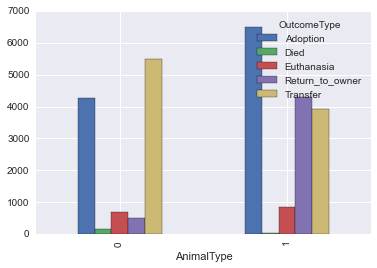

In [12]:
pd.crosstab(train_df.AnimalType, train_df.OutcomeType).plot.bar()

In [13]:
# So let's see what outcomes we're mapping against.

outcomes = train_df.OutcomeType.unique()
outcomes

array(['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died'], dtype=object)

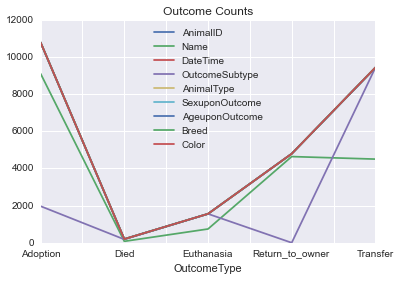

In [14]:
# Let's explore the data a bit more.  How do these outcomes map to our data?

counts = train_df.groupby('OutcomeType').count()
counts.plot.line(title="Outcome Counts")

Next we'll look at the outcome subtype. This isn't an element of our test data, so we shouldn't build it directly into our classifier, but we can use it to help us understand our data.

As an aside, this seems like very useful data to have on intake (and it bumps our accuracy up to 80+% when we use it).

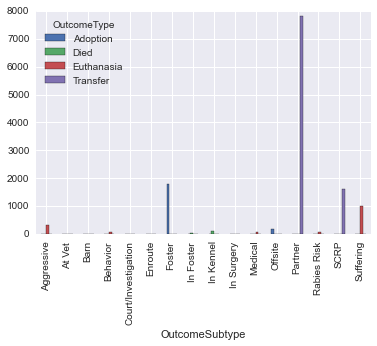

In [15]:
dates_cross = pd.crosstab(train_df.OutcomeSubtype, train_df.OutcomeType)
dates_cross.plot.bar()

Interesting. The outcome types are fairly siloed depending on the subtype.  Some questions:
* Where do transferred animals go?  Is shuffling them around an issue?  What are the outcomes after the transfer?
* At what point do the behavior, agression and suffering subtype outcomes come into play?

We need to transform the string categories into integers to work with the machine learning models.

Let's start by doing this for the animal sex feature.

In [16]:
# First, let's check out the different values

train_df.SexuponOutcome.unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown', nan], dtype=object)

There are actually two variables in SexuponOutcome - whether or not the animal is neutered/spayed or not and then male and female.

Let's break this down.

In [17]:
intact_list = []
gender_list = []

def sort_sexuponoutcome(sex_string):
    try:
        intact, gender = sex_string.split()
    except (AttributeError, ValueError) as e:
        intact, gender = "Neutered Male".split()
    
    if intact == "Intact":
        intact_list.append(1)
    else:
        intact_list.append(0)
        
    if gender == "Male":
        gender_list.append(1)
    else:
        gender_list.append(0)


In [18]:
train_df.SexuponOutcome.apply(sort_sexuponoutcome)
len(intact_list)

26729

In [19]:
print(train_df.SexuponOutcome[:5], intact_list[:5], gender_list[:5])

0    Neutered Male
1    Spayed Female
2    Neutered Male
3      Intact Male
4    Neutered Male
Name: SexuponOutcome, dtype: object [0, 0, 0, 1, 0] [1, 0, 1, 1, 1]


In [20]:
train_df['Intact'] = intact_list
train_df['Gender'] = gender_list

In [21]:
train_df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Intact,Gender
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,1,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,0,1
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,0,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,0,0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,1,Neutered Male,2 years,Pit Bull Mix,Blue/White,0,1
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,0,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,1,1
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,1,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,0,1


This seems like a good breakdown.

In [22]:
train_df.AgeuponOutcome.unique()

array(['1 year', '2 years', '3 weeks', '1 month', '5 months', '4 years',
       '3 months', '2 weeks', '2 months', '10 months', '6 months',
       '5 years', '7 years', '3 years', '4 months', '12 years', '9 years',
       '6 years', '1 weeks', '11 years', '4 weeks', '7 months', '8 years',
       '11 months', '4 days', '9 months', '8 months', '15 years',
       '10 years', '1 week', '0 years', '14 years', '3 days', '6 days',
       '5 days', '5 weeks', '2 days', '16 years', '1 day', '13 years', nan,
       '17 years', '18 years', '19 years', '20 years'], dtype=object)

And now we come to age.  This seems to be a text field, but pretty standard, so we'll just set up a quick function to group it into standard age groups (pulled from doggie websites). Possible issue: dogs of different sizes age differently. (Should we convert breed to size and modify the age feature?)

In [23]:
period_dict = {'year': 365, 'month': 30, 'week': 7, 'day': 1, 'day': 1}

age_group = {0: "infant", 1: "adolescent", 2: "adult", 3: "senior"}

def convert_age_to_group(age):
    # Convert input age into age groupings
    try:
        number, period = str(age).split()
        period = period.rstrip("s")
        days = int(number) * period_dict[period]
        
        if days < 365:
            return 0
        elif days < 730:
            return 1
        elif days < 2190:
            return 2
        else:
            return 3
        
    except ValueError:
        return 3
    

In [24]:
# Test our script

age_group[convert_age_to_group('8 weeks')]

'infant'

And we transform the AgeuponOutcome column to our groups.

In [25]:
train_df['AgeuponOutcome'] = train_df.AgeuponOutcome.apply(convert_age_to_group)

In [26]:
train_df.AgeuponOutcome.unique()

array([1, 2, 0, 3])

Now that we've grouped our data, let's look at how age effects outcome.

In [27]:
ages_n_outcomes = pd.crosstab(train_df.AgeuponOutcome, train_df.OutcomeType)

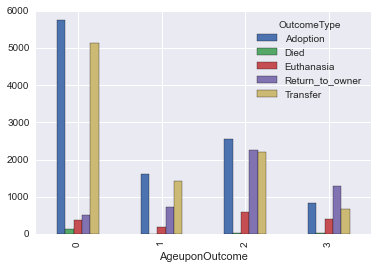

In [28]:
ages_n_outcomes.plot.bar()

Of interest here is the previous graph that showed that euthanized dogs were related to the OutcomeSubtypes for agression, etc.

So, we see that puppies are more likely to be adopted and adults are more likely to be euthanized, but looking at our counts again will help us interpret this data.

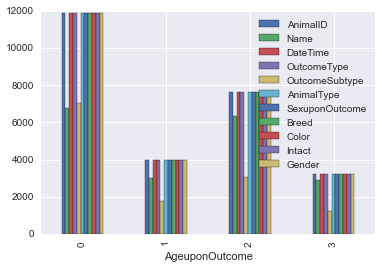

In [29]:
counts = train_df.groupby('AgeuponOutcome').count().plot.bar()

We should really do the same thing with color... But we're short on time here.

In [30]:
train_df.Color.unique()

array(['Brown/White', 'Cream Tabby', 'Blue/White', 'Blue Cream', 'Tan',
       'Black/Tan', 'Blue Tabby', 'Brown Tabby', 'Red/White', 'White',
       'Black', 'Silver', 'Brown', 'Black/Red', 'White/Cream',
       'Orange Tabby/White', 'Black/White', 'Brown Brindle/White',
       'Black/Brown', 'Orange Tabby', 'Chocolate/White', 'White/Tan',
       'Cream Tabby/White', 'Blue', 'Calico', 'Torbie', 'Brown/Black',
       'Yellow', 'Tricolor', 'White/Black', 'Tortie', 'Blue Tabby/White',
       'Gray/White', 'Tan/Black', 'Tan/White', 'Buff', 'Brown Tabby/White',
       'Red', 'Blue/Tan', 'Seal Point', 'Brown Brindle', 'White/Brown',
       'Gray', 'Yellow Brindle/White', 'Fawn/White', 'Flame Point',
       'Black Tabby/White', 'Tortie/Calico', 'Black/Brown Brindle',
       'White/Gray', 'Tan/Silver', 'Red Tick/Black', 'White/Cream Tabby',
       'Blue Merle', 'Chocolate/Tan', 'Sable', 'Brown Merle/White',
       'Brown Tiger/White', 'Liver/White', 'White/Blue Tabby',
       'Black/Gray', 'C

Some people really like their animals...  That is a lot of colours.

In [31]:
len(train_df.Color.unique())

366

We're still exploring here, so we will radically simplify the list.

In [32]:
def simplify_colors(color):
    sc = color.lower().replace("/"," ").split(" ")
    return sc[0]

In [33]:
simplify_colors("Black Brindle/Brown")

'black'

In [34]:
train_df.Color = train_df.Color.apply(simplify_colors)

In [35]:
len(train_df.Color.unique())

29

In [36]:
color = {}

transform_string_label_to_integer(color, train_df.Color)
    
train_df['Color'] = train_df.Color.map( color ).astype(int)

In [37]:
# We could also do something very cool with text analysis for names, but we'll keep it simple and go length

train_df['NameLength'] = train_df.Name.apply(lambda x: len(str(x)))

We've done a lot of pre-processing and have a good idea what our dataset looks like.  The Breed feature will be tricky, though, so let's save what we've done.

In [38]:
train_df.interpolate(inplace=True) # could have used dropna().median()
train_df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Intact,Gender,NameLength
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,1,Neutered Male,1,Shetland Sheepdog Mix,0,0,1,7
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,0,Spayed Female,1,Domestic Shorthair Mix,1,0,0,5
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,1,Neutered Male,2,Pit Bull Mix,2,0,1,6
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,0,Intact Male,0,Domestic Shorthair Mix,2,1,1,3
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,1,Neutered Male,2,Lhasa Apso/Miniature Poodle,3,0,1,3


In [39]:
# Save our clean dataframe to csv so we don't need to do this again.
train_df.to_csv(os.path.join(data_dir, "animals_clean_train.csv"))

### Gensim LSI for Breed types

In [40]:
# Let's reload our dataframe.

train_df = pd.read_csv(os.path.join(data_dir, "animals_clean_train.csv"), index_col=0)

In [41]:
train_df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Intact,Gender,NameLength
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,1,Neutered Male,1,Shetland Sheepdog Mix,0,0,1,7
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,0,Spayed Female,1,Domestic Shorthair Mix,1,0,0,5
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,1,Neutered Male,2,Pit Bull Mix,2,0,1,6
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,0,Intact Male,0,Domestic Shorthair Mix,2,1,1,3
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,1,Neutered Male,2,Lhasa Apso/Miniature Poodle,3,0,1,3


And look at the Breed feature.

In [42]:
len(train_df.Breed.unique())

1380

That is a lot of breeds...

### Document tokenization

In [43]:
def split_into_lemmas(message):
    # transform texts into tokens and preprocess
    words = TextBlob(message.replace("/", " ").lower()).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

In [44]:
breed_dict = train_df.Breed.apply(split_into_lemmas)

In [45]:
breed_dict[:5]

0           [shetland, sheepdog, mix]
1          [domestic, shorthair, mix]
2                    [pit, bull, mix]
3          [domestic, shorthair, mix]
4    [lhasa, apso, miniature, poodle]
Name: Breed, dtype: object

In [46]:
dictionary = corpora.Dictionary(breed_dict)
dictionary.save(os.path.join(data_dir, "breeds.dict"))
print(dictionary.token2id)

{'mouth': 39, 'flat': 20, 'afghan': 116, 'dane': 55, 'devon': 107, 'scottish': 106, 'corso': 216, 'labrador': 33, 'jack': 63, 'skye': 167, 'chinese': 91, 'treeing': 57, 'irish': 178, 'tibetan': 64, 'pit': 5, 'finnish': 198, 'landseer': 180, 'bichon': 140, 'tolling': 227, 'presa': 221, 'brindle': 212, 'belgian': 175, 'italian': 101, 'turkish': 244, 'cardigan': 49, 'cocker': 85, 'beagle': 37, 'mountain': 99, 'rex': 108, 'tervuren': 255, 'sharpei': 92, 'setter': 142, 'highland': 121, 'russian': 31, 'chin': 242, 'shorthair': 4, 'javanese': 200, 'walker': 58, 'canaan': 194, 'elkhound': 247, 'manx': 83, 'persian': 185, 'basset': 81, 'collie': 34, 'rat': 66, 'medium': 53, 'neapolitan': 224, 'whippet': 77, 'russell': 62, 'basenji': 159, 'foxhound': 46, 'bull': 6, 'maltese': 43, 'great': 18, 'keeshond': 202, 'british': 207, 'pug': 136, 'cattle': 72, 'bengal': 139, 'pinscher': 65, 'hound': 26, 'welsh': 50, 'field': 201, 'picardy': 203, 'cornish': 193, 'chesa': 79, 'akita': 93, 'cane': 215, 'tonk

Now we set up to pre-process the breed tokens and get them ready for analysis.

In [47]:
stoplist = '''
mix blend mutt black blue red white brown orange st terr de tan smooth
soft dog long short hair
'''.split()

stop_ids = [dictionary.token2id[stopword] for stopword in stoplist 
            if stopword in dictionary.token2id]
once_ids = [tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq == 1]
dictionary.filter_tokens(stop_ids + once_ids) # remove stop words and words that appear only once
dictionary.compactify() # remove gaps in id sequence after words that were removed
print(dictionary)

Dictionary(228 unique tokens: ['shih', 'mouth', 'tibetan', 'dane', 'bulldog']...)


Some of the issues here:

* Some of the breeds have colours including (which double counts the feature)
* There are a lot of generic terms, like mix & medium that don't add very much value.

In [48]:
corpus = [dictionary.doc2bow(text) for text in breed_dict]

In [49]:
corpora.MmCorpus.serialize(os.path.join(data_dir, "breed_corpus.mm"), corpus)
print(len(corpus))

26729


Okay, so we have our corpus, but we still don't know the right number of topics.  For this we'll use Latent Semantic Indexing (LSI) via Sklearn.  The code here is pulled from a great "Topic Modelling with Gensim" in the Salmon Run page.

http://sujitpal.blogspot.ca/2014/08/topic-modeling-with-gensim-over-past.html

Next we need to set up a Term-frequency, inverse document frequency transformer. This is a statistical way of determining which words are most important out of a corpus.

You can learn more about feature extraction here: http://scikit-learn.org/stable/modules/feature_extraction.html

In [50]:
tfidf = models.TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]
print(len(corpus_tfidf), len(train_df))

26729 26729


In [51]:
def split_into_lemmas(message):
    # transform texts into tokens and preprocess
    words = TextBlob(message.replace("/", " ").lower()).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

In [52]:
# Project to 2 dimensions for visualization
lsi = models.lsimodel.LsiModel(corpus_tfidf, id2word=dictionary, 
                               num_topics=2)

In [54]:
len(lsi[corpus])

26729

In [55]:
# write out coordinates to file
fcoords = open(os.path.join(data_dir, "coords.csv"), 'w')
for vector in lsi[corpus]:
    if len(vector) != 2:
        continue
    fcoords.write("%6.4f\t%6.4f\n" % (vector[0][1], vector[1][1]))
fcoords.close()

In [58]:
from sklearn.cluster import KMeans

The following graph runs a KMeans analysis against different K values and graphs the inertia.  When we start hitting diminishing returns, we know we're close to our optimal number of clusters.

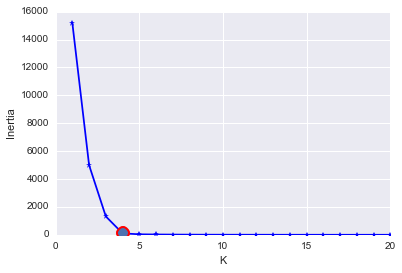

In [57]:
MAX_K = 20

X = X = np.loadtxt(os.path.join(data_dir, "coords.csv"), delimiter="\t")
ks = range(1, MAX_K + 1)

inertias = np.zeros(MAX_K)
diff = np.zeros(MAX_K)
diff2 = np.zeros(MAX_K)
diff3 = np.zeros(MAX_K)
for k in ks:
    kmeans = KMeans(k).fit(X)
    inertias[k - 1] = kmeans.inertia_
    # first difference    
    if k > 1:
        diff[k - 1] = inertias[k - 1] - inertias[k - 2]
    # second difference
    if k > 2:
        diff2[k - 1] = diff[k - 1] - diff[k - 2]
    # third difference
    if k > 3:
        diff3[k - 1] = diff2[k - 1] - diff2[k - 2]

elbow = np.argmin(diff3[3:]) + 3

plt.plot(ks, inertias, "b*-")
plt.plot(ks[elbow], inertias[elbow], marker='o', markersize=12,
         markeredgewidth=2, markeredgecolor='r', markerfacecolor=None)
plt.ylabel("Inertia")
plt.xlabel("K")
plt.show()

From the graph above, we can see that 4 clusters seems to be optimal for our analysis of breeds. Let's graph the 4 clusters now.

/Users/christopherallison/.virtualenvs/py_twi/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


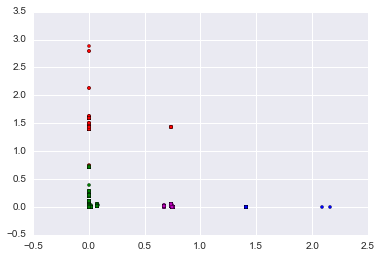

In [59]:
# Rerun Kmeans with num_topics = 4
NUM_TOPICS = 4

X = np.loadtxt(os.path.join(data_dir, "coords.csv"), delimiter="\t")
kmeans = KMeans(NUM_TOPICS).fit(X)
y = kmeans.labels_

colors = ["b", "g", "r", "m"]
for i in range(X.shape[0]):
    plt.scatter(X[i][0], X[i][1], c=colors[y[i]], s=10)    
plt.show()

Okay, so we're now reasonably solid that we should have four topics, so let's run the LDA and look at our top topics.

In [61]:
lda = models.ldamulticore.LdaMulticore(corpus=corpus, id2word=dictionary,
                         num_topics=4, passes=10)

lda.top_topics(corpus)

[([(0.350747876553335, 'domestic'),
   (0.3408810656770499, 'shorthair'),
   (0.090857499177837503, 'bull'),
   (0.089010779519540409, 'pit'),
   (0.054565861273571423, 'terrier'),
   (0.011263139901806895, 'russell'),
   (0.01010105210861687, 'jack'),
   (0.0097555979382260155, 'rat'),
   (0.0096284285158921533, 'yorkshire'),
   (0.0066368673307000995, 'cairn'),
   (0.0029006770138118284, 'snowshoe'),
   (0.0024189587611232652, 'american'),
   (0.0019984445962260063, 'rhod'),
   (0.001998114849142728, 'ridgeback'),
   (0.0012163340795225738, 'norfolk'),
   (0.001171762087865863, 'parson'),
   (0.00086112154738827106, 'harrier'),
   (0.0007401517243946933, 'frise'),
   (0.00074009481256164444, 'bichon'),
   (0.00068592847705521449, 'norwich')],
  -1538.7758801028381),
 ([(0.19254709885967733, 'chihuahua'),
   (0.18291004919538836, 'retriever'),
   (0.16980259795742245, 'labrador'),
   (0.16493651463526335, 'shorthair'),
   (0.022887284391509687, 'hound'),
   (0.022502853562933738, 'bea

This actually looks pretty good... except I can't find the cats and, at minimum, they've been grouped together with the dogs.  Because we are predicting based on animaltype as well, this might not be as serious an issue as it appears.

Now we create a bag of words transformer based on the full texts in the Breed feature.

In [62]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer()

bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(train_df.Breed)
len(bow_transformer.vocabulary_)

bow_transformer.get_feature_names()[3]

breed_bow = bow_transformer.transform(train_df.Breed)
print( 'sparse matrix shape:', breed_bow.shape)
print( 'number of non-zeros:', breed_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * breed_bow.nnz / (breed_bow.shape[0] * breed_bow.shape[1])))

# First, we fit the transformer to our BoW

tfidf_transformer = TfidfTransformer().fit(breed_bow)

breed_tfidf = tfidf_transformer.transform(breed_bow)

for e in breed_tfidf[5]:
    print(e)

sparse matrix shape: (26729, 262)
number of non-zeros: 80537
sparsity: 1.15%
  (0, 237)	0.470921349262
  (0, 214)	0.22922693304
  (0, 58)	0.41279380185
  (0, 47)	0.745177410509


From here, we can cluster the breed data using several options.

## KMeans Clustering

Let's do this again using our previous code, just for kicks.

In [63]:
# Select number of clusters for KMeans clustering - now 4 clusters
n_clusters = 4

In [64]:
# Import and set up our classifier

from sklearn.cluster import KMeans

km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1, verbose=1)

In [65]:
# Fit the KM classifier on our TFIDF

km_breeds = km.fit_predict(breed_tfidf)

Initialization complete
Iteration  0, inertia 23354.038
Iteration  1, inertia 15349.388
Iteration  2, inertia 13188.561
Iteration  3, inertia 12909.218
Iteration  4, inertia 12908.782
Iteration  5, inertia 12908.529
Iteration  6, inertia 12908.524
Converged at iteration 6


KMeans stops when it stops making progress on it's clustering.

Now we have a working machine learning classifier on which we can predict our feature.

In [66]:
km.predict(breed_tfidf[4])

array([0], dtype=int32)

In [67]:
train_df['BreedKMeans'] = km_breeds

In [68]:
train_df.head(1)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Intact,Gender,NameLength,BreedKMeans
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,1,Neutered Male,1,Shetland Sheepdog Mix,0,0,1,7,0


In [69]:
train_df.columns

Index(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
       'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color',
       'Intact', 'Gender', 'NameLength', 'BreedKMeans'],
      dtype='object')

In [70]:
X = train_df.drop(['AnimalID', 'Name', "DateTime", "OutcomeSubtype",
                  "SexuponOutcome", 'Breed', ], axis=1)

X.dtypes

OutcomeType       object
AnimalType         int64
AgeuponOutcome     int64
Color              int64
Intact             int64
Gender             int64
NameLength         int64
BreedKMeans        int32
dtype: object

In [71]:
X.head()

,OutcomeType,AnimalType,AgeuponOutcome,Color,Intact,Gender,NameLength,BreedKMeans
0,Return_to_owner,1,1,0,0,1,7,0
1,Euthanasia,0,1,1,0,0,5,1
2,Adoption,1,2,2,0,1,6,3
3,Transfer,0,0,2,1,1,3,1
4,Transfer,1,2,3,0,1,3,0


In [72]:
X.to_csv(os.path.join(data_dir, "prepared_animals_df.csv"))

In [73]:
# Visualizing the K-Means clusters via TSNE
# t-distributed Stochastic Neighbor Embedding.

from sklearn.manifold import TSNE

http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [74]:
# First we use the TruncatedSVD to perform linear dimensionality reduction (truncated singular value decomposition (SVD)).

from sklearn.decomposition import TruncatedSVD

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(breed_tfidf)

In [75]:
# Note - you need a fairly high-powered system to run the TSNE with this dataset. An i7 with 16gb ram works fine.
# N_components refers to bringing the multi-dimensional space down to 2 dimensions, which lets us graph it.

X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 26729
[t-SNE] Computed conditional probabilities for sample 2000 / 26729
[t-SNE] Computed conditional probabilities for sample 3000 / 26729
[t-SNE] Computed conditional probabilities for sample 4000 / 26729
[t-SNE] Computed conditional probabilities for sample 5000 / 26729
[t-SNE] Computed conditional probabilities for sample 6000 / 26729
[t-SNE] Computed conditional probabilities for sample 7000 / 26729
[t-SNE] Computed conditional probabilities for sample 8000 / 26729
[t-SNE] Computed conditional probabilities for sample 9000 / 26729
[t-SNE] Computed conditional probabilities for sample 10000 / 26729
[t-SNE] Computed conditional probabilities for sample 11000 / 26729
[t-SNE] Computed conditional probabilities for sample 12000 / 26729
[t-SNE] Computed conditional probabilities for sample 13000 / 26729
[t-SNE] Computed conditional probabilities

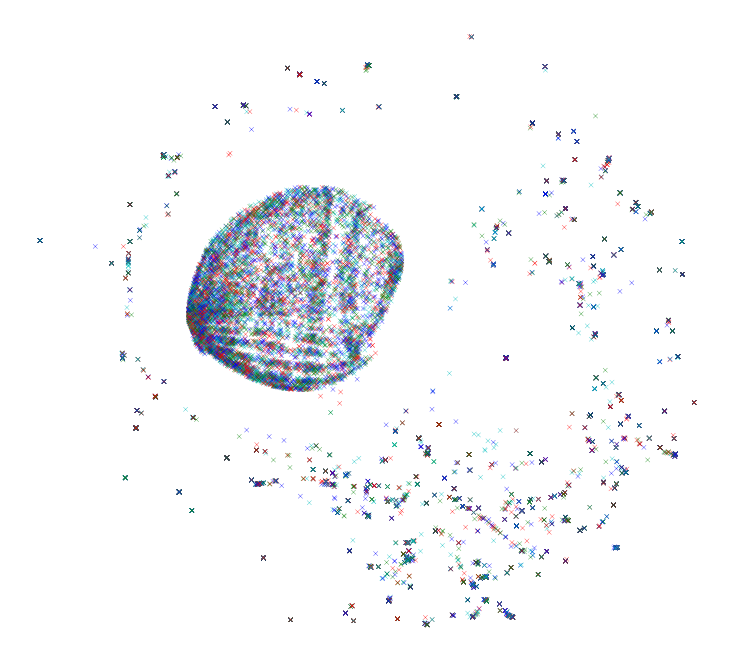

In [82]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=['g', 'b', 'r', 'c'], marker="x")

This plot looks significantly different from our previous plot with only dog breeds. We've also done a deeper analysis, so the difference makes sense, but I would have expected to see greater differentiation in the clusters.

### Frome here, go to the Random Forest Classifier to try out your machine learning model.